In [25]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

## 1️ Load the Dataset

We are using the **Online Retail dataset** from the UCI Machine Learning Repository.  
This dataset contains e-commerce transactions for a UK-based online retailer.  

- Columns: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country  
- Purpose: To analyze customer purchase behaviour for segmentation using RFM analysis.  


In [26]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [27]:
df.shape

(541909, 8)

In [28]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## 2 Data Cleaning

 Before performing RFM analysis, we need to clean the dataset (using EDA) to ensure the results are accurate.  
 I applied the following data cleaning steps:

1. **Removed rows with missing `CustomerID`**  
   - These customers can't be tracked over time, which is essential for RFM.  
   - About 135080 rows (a significant portion) had no CustomerID and were dropped.Because RFM is calculated per customer,
   I can’t group or track customers without an ID, so removing those rows was the only valid option.  

2. **Removed cancelled transactions**  
   - Invoices starting with `"C"` indicate cancelled orders.  
   - These would distort the frequency and monetary value, so I removed them.  

3. **Removed rows with missing `Description`**  
   - Around 1,454 rows had no product description.  
   - Since product name is not used in RFM, these rows were dropped for consistency.  

4. **Removed rows with non-positive `Quantity` or `UnitPrice`**  
   - These include returns


In [29]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [30]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [31]:
print("Missing descriptions:", df['Description'].isna().sum())
df = df[df['Description'].notnull()]

Missing descriptions: 0


In [32]:
df = df[df['CustomerID'].notnull()]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [33]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']


In [34]:
df.shape

(397884, 9)

## 3 Calculate RFM Metrics

I grouped the data by `CustomerID` and calculated:

- **Recency (R):** Days since last purchase (lower is better).  
- **Frequency (F):** Number of unique purchase invoices.  
- **Monetary (M):** Total amount spent.  

These three metrics give a complete picture of customer behavior.


In [35]:
# Set snapshot date to one day after the last invoice
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM per CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalSum': 'sum'                                          # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

#positive spenders
rfm = rfm[rfm['Monetary'] > 0]

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## 4 Assign RFM Scores

To rank customers:


- I assigned scores 1 (low) to 4 (high) for each R, F, and M metric using quartiles.  
- Recent buyers, frequent buyers, and high spenders get **higher scores**.  
- Combined all three scores to get a total **RFM_Score** and an **RFM_Segment** code (e.g., 443).  


In [36]:
# Score each metric from 1 (low) to 4 (high)
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Score'] = rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,114,6
1,12347.0,2,7,4310.00,4,4,4,444,12
2,12348.0,75,4,1797.24,2,3,4,234,9
3,12349.0,19,1,1757.55,3,1,4,314,8
4,12350.0,310,1,334.40,1,1,2,112,4


## 5 Create Customer Segments

Based on RFM_Score, we divided customers into segments such as:

- **Champions:** Highest scores – recent, frequent, and high-spending customers.  
- **Loyal Customers:** Often Buy and spend consistently.  
- **Potential Loyalists:** Could become loyal with the right incentives.  
- **At Risk:** Haven’t purchased in a long time, may need re-engagement.  

This segmentation allows targeted marketing strategies for each group.


In [37]:
def segment_customer(score):
    if score >= 9:
        return 'Champions'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalist'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Check segment distribution
rfm['Segment'].value_counts()


Segment
Champions             1679
Potential Loyalist     988
Loyal Customers        864
At Risk                807
Name: count, dtype: int64

## 6 Visualize the Segments

We created visualizations to understand the distribution of customers:

- **Bar Chart:** Number of customers in each segment.  
- **Heatmap:** Shows average monetary value by Recency and Frequency scores.  

These visuals help stakeholders quickly identify the most valuable segments.


C:\Users\Hp\AppData\Local\Temp\ipykernel_13568\3028800140.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')


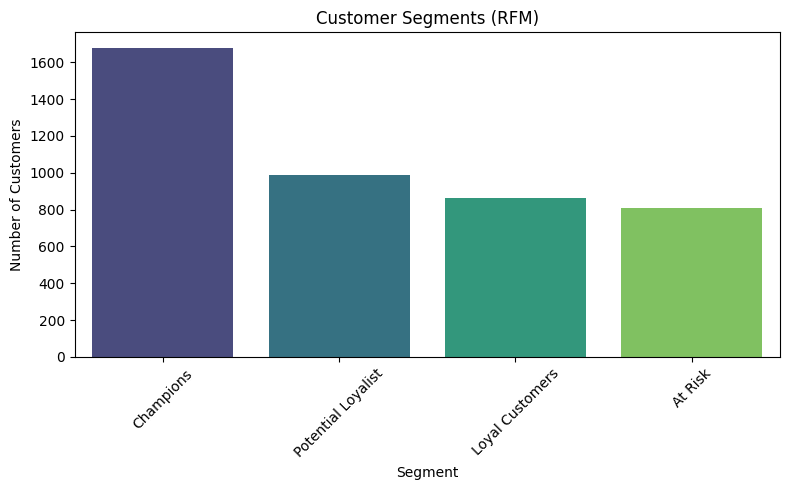

In [38]:
# Bar plot
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title("Customer Segments (RFM)")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


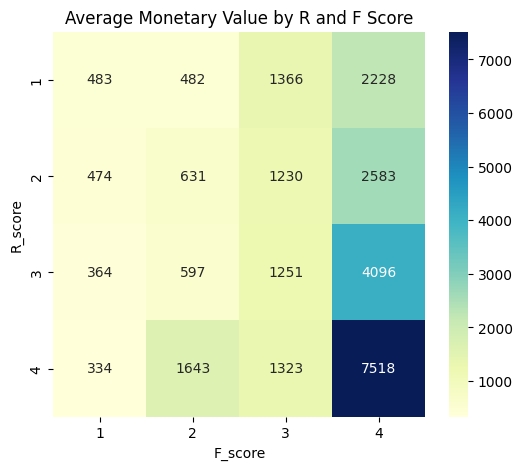

In [39]:
# Heatmap of RFM combinations
rfm_pivot = rfm.pivot_table(index='R_score', columns='F_score', values='Monetary', aggfunc='mean')
plt.figure(figsize=(6,5))
sns.heatmap(rfm_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title("Average Monetary Value by R and F Score")
plt.show()


## 7 Marketing Insights

By analyzing the RFM segments, here are suggested strategies that can maximize customer lifetime value:

- **Champions (Top RFM scores):**  
  - These customers buy frequently, spend the most, and purchased recently.  
  - **Strategy:** Reward them with exclusive rewards, early access to new products, and VIP programs to strengthen loyalty and turn them into brand advocates.  

- **Loyal Customers (High frequency, good spenders):**  
  - They consistently purchase, but may not be the highest spenders.  
  - **Strategy:** Introduce tier-based loyalty points, referral bonuses, and personalized recommendations to increase average order value.  

- **Potential Loyalists (Good recent activity but lower frequency):**  
  - They have shown interest but haven't purchased frequently yet.  
  - **Strategy:** Nurture them with onboarding offers, targeted product bundles, and personalized discounts to encourage repeat purchases.  

- **At Risk (Low recency, low frequency):**  
  - These customers are slipping away and may churn.  
  - **Strategy:** Re-engage with win-back campaigns, time-limited offers, or surveys to understand why they stopped buying.  

These insights allow businesses to allocate resources more effectively and create personalized campaigns that improve retention, reactivation, and revenue growth.
